In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import cnn
from sklearn.model_selection import KFold

import os
import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

In [3]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
#             if self.test is False:
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
#                 rotate = np.random.randint(4, size=1)
#                 if rotate:
#                     img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            pass
        img = torch.from_numpy(img).type(dtype)
        img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

# def data_aug(X, y):    
#     X_rot_30 = []
#     X_rot_60 = [] 
#     X_h = np.flip(X, 3)
#     X_v = np.flip(X, 2)
#     for i in X:
#         X_rot_30.append(tf.rotate(i,angle=30,resize=False))
#         X_rot_60.append(tf.rotate(i,angle=60,resize=False))
        
#     X_rot_30 = np.stack(X_rot_30)
#     X_rot_60 = np.stack(X_rot_60)
#     ch_y = np.concatenate((y,y,y,y,y))
#     ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
#     return ch_X, ch_y

def data_aug(X, y):    
    X_rot_30 = []
    X_rot_60 = [] 
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_30.append(tf.rotate(i,angle=90,resize=False))
        X_rot_60.append(tf.rotate(i,angle=270,resize=False))
        
    X_rot_30 = np.stack(X_rot_30)
    X_rot_60 = np.stack(X_rot_60)
    ch_y = np.concatenate((y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
    return ch_X, ch_y


def data_aug2(X, y):    
    X_rot_90 = []
    X_rot_180 = []
    X_rot_270 = []
    X_rot_90_hflip = []
    X_rot_270_hflip = []
    
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_90.append(tf.rotate(i,angle=90,resize=False))
        X_rot_180.append(tf.rotate(i,angle=180,resize=False))
        X_rot_270.append(tf.rotate(i,angle=270,resize=False))
        X_rot_90_hflip.append(np.flip(tf.rotate(i,angle=90,resize=False),2))
        X_rot_270_hflip.append(np.flip(tf.rotate(i,angle=270,resize=False),2))
    
    
    X_rot_90 = np.stack(X_rot_90)
    X_rot_180 = np.stack(X_rot_180)
    X_rot_270 = np.stack(X_rot_270 )
    X_rot_90_hflip = np.stack(X_rot_90_hflip)
    X_rot_270_hflip = np.stack(X_rot_270_hflip)
    
    ch_y = np.concatenate((y,y,y,y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v,X_rot_90,X_rot_180,X_rot_270,X_rot_90_hflip,X_rot_270_hflip))
    return ch_X, ch_y





train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [18]:
#data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
sum(np.where(data.inc_angle > 0)[0])

1470

In [4]:
# train_index=list(range(1300))
# val_index= list(range(1300,1604))
# train_index=list(range(304,1604)) 
# val_index= list(range(304))
# # train_X[train_index].shape

# # seed= np.random.RandomState(123)
# # spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# # train_index, val_index = next(spliter.split(train_X))
# train_mean, train_std = transform_compute(train_X[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

## add augmentation 
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))

# train_X_af,train_y_af = data_aug(train_X[train_index], train_y[train_index])
# train_mean, train_std = transform_compute(train_X_af)
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X_af, label=train_y_af, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

#data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
# train_X_del = train_X[data.inc_angle!='na',:,:,:]
# train_y_del = train_y[data.inc_angle!='na']
# # # train_X_del = train_X
# # # train_y_del = train_y

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X_del))
# # # train_index=list(range(284,1471)) 
# # # val_index= list(range(284))

# train_mean, train_std = transform_compute(train_X_del[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])
# #af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])
# af_train_X, af_train_y = data_aug2(train_X_del[train_index], train_y_del[train_index])
# #af_train_X, af_train_y = train_X_del[train_index], train_y_del[train_index]

# train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

###########################################################################
# train_index=list(range(1604)) 
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
# train_mean, train_std = transform_compute(train_X[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])


## For final training
train_X_del = train_X[data.inc_angle!='na',:,:,:]
train_y_del = train_y[data.inc_angle!='na']

train_mean, train_std = transform_compute(train_X_del)
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])


In [23]:
# torch.cuda.is_available()
# torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
# train_X[1]
# use_cuda
optimizer.param_groups[0]['lr']

0.0005

In [7]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'cnn_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'cnn_loss.pth')
                
        if loss_avg/total < 0.18 and val_loss < 0.18:
            torch.save(net.state_dict(), 'spec_cnn_acc.pth')
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

In [8]:
result = []
for i in range(2):
    cnn_net = cnn.plain_cnn(num_classes=2)
    net= cnn_net

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here   
    #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00175, nesterov= True)
    #optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.0001)
    #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.0001)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
    #     cudnn.benchmark = True   

    result.append(train(epoch=200,early_stopping= 20))


This is epoch:1
[========= 294/294 ======>]Step: 0ms| Tot: 4s6ms|Loss: 0.590 | Acc: 67.815% (6380/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.447 | Acc: 80.000% (236/295)
acc: Save it!

This is epoch:2
[========= 294/294 ======>]Step: 0ms| Tot: 4s6ms|Loss: 0.490 | Acc: 76.637% (7210/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.389 | Acc: 84.407% (249/295)
acc: Save it!

This is epoch:3
[========= 294/294 ======>]Step: 0ms| Tot: 4s5ms|Loss: 0.461 | Acc: 78.306% (7367/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.370 | Acc: 84.407% (249/295)

This is epoch:4
[========= 294/294 ======>]Step: 0ms| Tot: 4s5ms|Loss: 0.431 | Acc: 79.826% (7510/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.375 | Acc: 83.051% (245/295)

This is epoch:5
[========= 294/294 ======>]Step: 0ms| Tot: 4s6ms|Loss: 0.408 | Acc: 80.729% (7595/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.297 | Acc: 86.102% (254/295)
acc: Save it!

This is epoc

[========= 294/294 ======>]Step: 0ms| Tot: 4s5ms|Loss: 0.289 | Acc: 87.022% (8187/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.236 | Acc: 88.814% (262/295)

This is epoch:37
[========= 294/294 ======>]Step: 0ms| Tot: 4s5ms|Loss: 0.282 | Acc: 87.511% (8233/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.217 | Acc: 90.508% (267/295)

This is epoch:38
[========= 294/294 ======>]Step: 0ms| Tot: 4s5ms|Loss: 0.287 | Acc: 87.341% (8217/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 89.831% (265/295)

This is epoch:39
[========= 294/294 ======>]Step: 0ms| Tot: 4s5ms|Loss: 0.281 | Acc: 87.394% (8222/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.232 | Acc: 91.525% (270/295)
acc: Save it!

This is epoch:40
[========= 294/294 ======>]Step: 0ms| Tot: 4s5ms|Loss: 0.291 | Acc: 86.639% (8151/9408)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.242 | Acc: 88.814% (262/295)

This is epoch:41
[========= 294/294 ======>]Step: 0ms

In [9]:
result

[(91.86440677966101, 48), (93.55932203389831, 97)]

In [76]:
##For continue training
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34
net.load_state_dict(torch.load('save_resnet34_acc.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00012, nesterov= True)
scheduler = MultiStepLR(optimizer, [50,100], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

#train(epoch=150)


test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)
result = []
for i in range(10):
    train(epoch=1)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    result.append(np.concatenate(prob))


This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s272ms | Loss: 0.175 | Acc: 92.538% (1203/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 171ms | Loss: 0.194 | Acc: 93.092% (283/304)
[=================== 132/132 ================>]  Step: 33ms | Tot: 5s848ms

This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s282ms | Loss: 0.169 | Acc: 92.846% (1207/1300)
[=================== 5/5 ============>........]  Step: 34ms | Tot: 168ms | Loss: 0.195 | Acc: 92.434% (281/304)
[=================== 132/132 ================>]  Step: 32ms | Tot: 5s827ms

This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s279ms | Loss: 0.176 | Acc: 92.154% (1198/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 170ms | Loss: 0.194 | Acc: 92.763% (282/304)
[=================== 132/132 ================>]  Step: 33ms | Tot: 5s807ms

This is epoch:1
[=================== 41

In [75]:
test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape

(8424, 3, 75, 75)

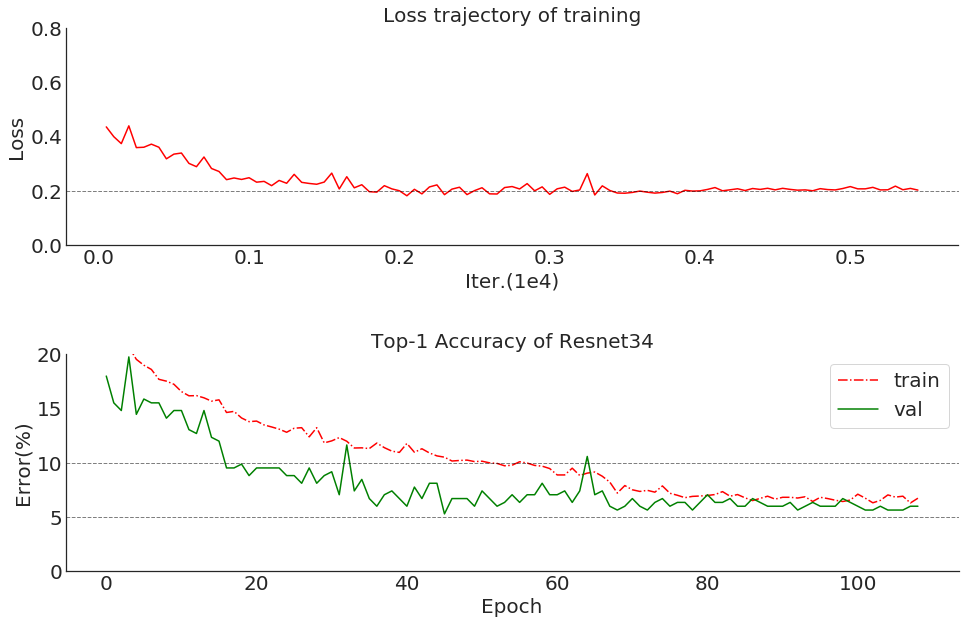

In [27]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.8))
fig1.axhline(y=[0.2],alpha=0.5, linestyle='--',color='k',linewidth=1)

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet34',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

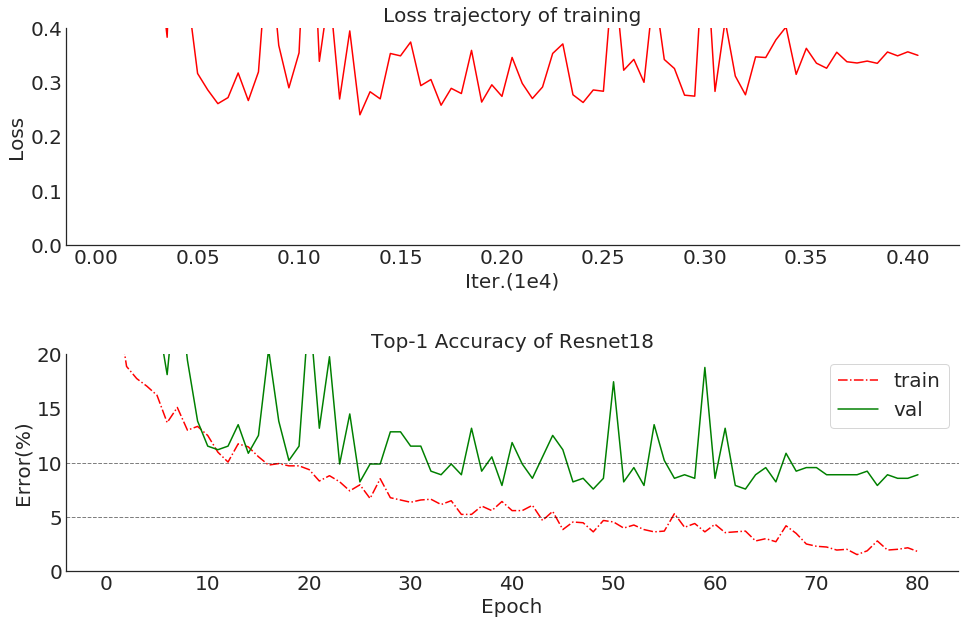

In [12]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [8]:
net = cnn.plain_cnn(num_classes=2)
net.load_state_dict(torch.load('save_cnn_loss20_1.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms


In [77]:
k =np.stack(result).mean(axis=0)
# #sub.shapesub.to_csv('submission2.csv',index=False)
# result[1].shape
# np.concatenate(prob).shape

In [9]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] =  np.concatenate(prob)
sub.shape
sub.to_csv('submissioniu.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [11]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'cnn_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                acc= best_acc+ 0.01
                print('loss: Save it!')
                torch.save(net.state_dict(), 'cnn_loss.pth')
            if loss_avg/total > val_loss:
                e_s = 0
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss, best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

#Try different transformation

for rou in range(4):
    ran_num = np.random.randint(20000,30000,size=1)
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
        
        train_mean, train_std = transform_compute(train_X_del[train_index])
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])
        af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])
        
        train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
        val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)
        
        candidate = []
        for rep in range(3):
            cnn_net = cnn.plain_cnn(num_classes=2)
            net= cnn_net

            criterion = nn.CrossEntropyLoss()

            optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00175, nesterov= True)
            scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.0001)
            #5e-3 86
            if use_cuda:
                criterion.cuda()
                net.cuda()

            result = train(epoch=250,early_stopping= 20)
            candidate.append(result[0])
            with open("plain_cnn_models/log.txt", "a") as myfile:
                msg = 'Phase3, At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                            k,ran_num,rep+1, result[1], result[0])
                myfile.write(msg)
            cmd = 'cp cnn_loss.pth r3_cnn_loss{}.pth'.format(rep)
            os.system(cmd)
            if len(candidate)==2:
                if np.sum(np.array(candidate)<0.18)>=1:
                    continue
                else:
                    break
#         if min(candidate)>0.2:
#             with open("plain_cnn_models/log.txt", "a") as myfile:
#                 msg = 'We are going to give up this round\n'
#                 myfile.write(msg)
                
#             g= candidate.index(min(candidate))
#             cmd = 'cp cnn_loss{}.pth plain_cnn_models_lossbackup/cnn{}_{}{}.pth'.format(g,rou,k,g)
#             os.system(cmd)
#             continue

        #actually an array
        #also change here
        final_list = np.union1d(np.where(np.array(candidate) <0.18)[0], [candidate.index(min(candidate))])
        final_list_v=[i for i in range(3) if i not in final_list]
        #final_list = list(range(len(candidate)))
        
        word= ''
        for i in np.array(candidate)[final_list]:
            word = word +', '+ str(i)
        
        
        for g in final_list:
            with open("plain_cnn_models/result.txt", "a") as myfile:
                msg = 'Phase3, At fold {}, seed {},round {} we find {} with loss: {}\n'.format(
                                                            k,ran_num,rep+1, len(final_list), word)
                myfile.write(msg)
            cmd = 'cp r3_cnn_loss{}.pth plain_cnn_models/r4_cnn{}_{}{}[good].pth'.format(g,rou,k,g)
            os.system(cmd)
        for g in final_list_v:
            with open("plain_cnn_models/result.txt", "a") as myfile:
                msg = 'Phase3, At fold {}, seed {},round {} we find {} with loss: {}\n'.format(
                                                            k,ran_num,rep+1, len(final_list), word)
                myfile.write(msg)
            cmd = 'cp r3_cnn_loss{}.pth plain_cnn_models/r4_cnn{}_{}{}[bad].pth'.format(g,rou,k,g)
            os.system(cmd)


This is epoch:1
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.607 | Acc: 67.704% (3981/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.527 | Acc: 77.627% (229/295)
acc: Save it!

This is epoch:2
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.503 | Acc: 75.884% (4462/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.474 | Acc: 77.966% (230/295)
acc: Save it!

This is epoch:3
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.461 | Acc: 78.435% (4612/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.351 | Acc: 85.085% (251/295)
acc: Save it!

This is epoch:4
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.450 | Acc: 79.048% (4648/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.332 | Acc: 84.407% (249/295)

This is epoch:5
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.424 | Acc: 80.391% (4727/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.343 | Acc: 82.712% (244/295)

This is epoc

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.211 | Acc: 91.864% (271/295)
acc: Save it!

This is epoch:43
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.212 | Acc: 90.884% (5344/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.246 | Acc: 90.508% (267/295)

This is epoch:44
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.216 | Acc: 90.408% (5316/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.212 | Acc: 91.864% (271/295)

This is epoch:45
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.209 | Acc: 91.054% (5354/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.222 | Acc: 91.186% (269/295)
loss: Save it!

This is epoch:46
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.200 | Acc: 91.412% (5375/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.223 | Acc: 91.525% (270/295)

This is epoch:47
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.209 | Acc: 91.497% (5380/5880)
[=========   5/  5 ==

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.255 | Acc: 91.864% (271/295)

This is epoch:85
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.160 | Acc: 93.265% (5484/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.244 | Acc: 92.542% (273/295)

This is epoch:86
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.148 | Acc: 93.912% (5522/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.245 | Acc: 92.881% (274/295)

This is epoch:87
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.153 | Acc: 93.503% (5498/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.246 | Acc: 92.203% (272/295)

This is epoch:88
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.142 | Acc: 94.031% (5529/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.263 | Acc: 92.203% (272/295)

This is epoch:89
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.145 | Acc: 94.048% (5530/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Los

[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.300 | Acc: 86.224% (5070/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.226 | Acc: 90.508% (267/295)

This is epoch:24
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.292 | Acc: 86.837% (5106/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.243 | Acc: 90.508% (267/295)

This is epoch:25
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.292 | Acc: 86.820% (5105/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.227 | Acc: 91.186% (269/295)

This is epoch:26
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.294 | Acc: 86.684% (5097/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.344 | Acc: 87.119% (257/295)
loss: Save it!

This is epoch:27
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.285 | Acc: 87.296% (5133/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.239 | Acc: 91.525% (270/295)
acc: Save it!

This is epoch:28
[========= 184/184 ==

[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.169 | Acc: 92.755% (5454/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 92.203% (272/295)

This is epoch:66
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.166 | Acc: 92.823% (5458/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.229 | Acc: 92.203% (272/295)

This is epoch:67
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.156 | Acc: 93.605% (5504/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.231 | Acc: 92.881% (274/295)

This is epoch:68
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.154 | Acc: 93.435% (5494/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 92.542% (273/295)

This is epoch:69
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.164 | Acc: 93.367% (5490/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.232 | Acc: 92.542% (273/295)

This is epoch:70
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|L

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.279 | Acc: 87.749% (5164/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.191 | Acc: 91.837% (270/294)

This is epoch:38
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.268 | Acc: 87.647% (5158/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.175 | Acc: 92.517% (272/294)

This is epoch:39
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.269 | Acc: 88.190% (5190/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.180 | Acc: 92.517% (272/294)

This is epoch:40
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.283 | Acc: 87.545% (5152/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.175 | Acc: 93.537% (275/294)
acc: Save it!

This is epoch:41
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.279 | Acc: 87.052% (5123/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.177 | Acc: 93.537% (275/294)

This is epoch:42
[========= 184/184 ======>]Step: 0ms

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.163 | Acc: 93.339% (5493/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.174 | Acc: 94.218% (277/294)

This is epoch:80
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.156 | Acc: 93.407% (5497/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.184 | Acc: 94.218% (277/294)

This is epoch:81
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.162 | Acc: 93.203% (5485/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.171 | Acc: 93.197% (274/294)

This is epoch:82
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.154 | Acc: 93.322% (5492/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.177 | Acc: 94.558% (278/294)

This is epoch:83
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.159 | Acc: 93.441% (5499/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.169 | Acc: 93.537% (275/294)

This is epoch:84
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|L

[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.312 | Acc: 85.981% (5060/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.225 | Acc: 90.136% (265/294)

This is epoch:24
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.306 | Acc: 86.168% (5071/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.202 | Acc: 91.156% (268/294)

This is epoch:25
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.308 | Acc: 85.879% (5054/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.225 | Acc: 90.136% (265/294)

This is epoch:26
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.305 | Acc: 86.134% (5069/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.216 | Acc: 91.497% (269/294)

This is epoch:27
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.294 | Acc: 86.780% (5107/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.222 | Acc: 90.476% (266/294)

This is epoch:28
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|L

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.169 | Acc: 93.197% (274/294)

This is epoch:66
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.182 | Acc: 92.421% (5439/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.165 | Acc: 93.537% (275/294)

This is epoch:67
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.181 | Acc: 92.184% (5425/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.172 | Acc: 93.878% (276/294)

This is epoch:68
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.181 | Acc: 92.268% (5430/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.175 | Acc: 92.857% (273/294)

This is epoch:69
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.182 | Acc: 92.099% (5420/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.180 | Acc: 92.857% (273/294)

This is epoch:70
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.182 | Acc: 92.116% (5421/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Los

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.290 | Acc: 87.415% (257/294)

This is epoch:10
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.386 | Acc: 82.005% (4826/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.264 | Acc: 88.776% (261/294)
acc: Save it!

This is epoch:11
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.372 | Acc: 82.413% (4850/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.291 | Acc: 87.415% (257/294)

This is epoch:12
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.364 | Acc: 83.161% (4894/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.289 | Acc: 87.075% (256/294)

This is epoch:13
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.350 | Acc: 83.585% (4919/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.256 | Acc: 89.116% (262/294)
acc: Save it!

This is epoch:14
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.353 | Acc: 83.483% (4913/5885)
[=========   5/  5 ==>

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.253 | Acc: 89.125% (5245/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.189 | Acc: 91.837% (270/294)

This is epoch:53
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.243 | Acc: 89.941% (5293/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.162 | Acc: 93.878% (276/294)

This is epoch:54
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.243 | Acc: 89.006% (5238/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.164 | Acc: 93.878% (276/294)

This is epoch:55
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.244 | Acc: 89.091% (5243/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 89.796% (264/294)

This is epoch:56
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.251 | Acc: 88.836% (5228/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.199 | Acc: 92.517% (272/294)

This is epoch:57
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|L

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.138 | Acc: 94.444% (5558/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.201 | Acc: 93.537% (275/294)

This is epoch:95
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.133 | Acc: 94.766% (5577/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.204 | Acc: 93.537% (275/294)

This is epoch:96
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.138 | Acc: 94.494% (5561/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.196 | Acc: 93.537% (275/294)

This is epoch:97
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.136 | Acc: 94.511% (5562/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.193 | Acc: 93.878% (276/294)

This is epoch:98
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.136 | Acc: 94.189% (5543/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.193 | Acc: 93.878% (276/294)

This is epoch:99
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|L

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.286 | Acc: 86.661% (5100/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.235 | Acc: 90.816% (267/294)

This is epoch:33
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.279 | Acc: 87.239% (5134/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.256 | Acc: 87.755% (258/294)

This is epoch:34
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.281 | Acc: 87.426% (5145/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.277 | Acc: 89.456% (263/294)

This is epoch:35
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.280 | Acc: 87.664% (5159/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.216 | Acc: 91.156% (268/294)

This is epoch:36
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.269 | Acc: 87.732% (5163/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.220 | Acc: 92.177% (271/294)
acc: Save it!

This is epoch:37
[========= 184/184 ======>]Step: 0ms

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.263 | Acc: 90.816% (267/294)

This is epoch:75
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.164 | Acc: 93.135% (5481/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.243 | Acc: 91.837% (270/294)

This is epoch:76
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.163 | Acc: 93.237% (5487/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.275 | Acc: 91.497% (269/294)

This is epoch:77
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.154 | Acc: 93.594% (5508/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.244 | Acc: 91.497% (269/294)

This is epoch:78
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.156 | Acc: 93.662% (5512/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 92.517% (272/294)

This is epoch:79
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.155 | Acc: 93.407% (5497/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Los

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.278 | Acc: 87.986% (5178/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.246 | Acc: 89.116% (262/294)

This is epoch:34
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.276 | Acc: 87.426% (5145/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 89.116% (262/294)

This is epoch:35
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.271 | Acc: 87.986% (5178/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.235 | Acc: 90.136% (265/294)

This is epoch:36
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.276 | Acc: 87.952% (5176/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.210 | Acc: 92.177% (271/294)
acc: Save it!

This is epoch:37
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.265 | Acc: 88.275% (5195/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.229 | Acc: 90.816% (267/294)

This is epoch:38
[========= 184/184 ======>]Step: 0ms

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.158 | Acc: 93.509% (5503/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.238 | Acc: 91.156% (268/294)

This is epoch:76
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.149 | Acc: 93.747% (5517/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.229 | Acc: 91.156% (268/294)

This is epoch:77
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.154 | Acc: 93.730% (5516/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 90.816% (267/294)

This is epoch:78
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.150 | Acc: 93.815% (5521/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.235 | Acc: 91.497% (269/294)

This is epoch:79
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.151 | Acc: 93.543% (5505/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.234 | Acc: 91.156% (268/294)

This is epoch:80
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|L

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.297 | Acc: 86.916% (5115/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.250 | Acc: 89.796% (264/294)

This is epoch:29
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.279 | Acc: 87.732% (5163/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.214 | Acc: 90.816% (267/294)

This is epoch:30
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.291 | Acc: 87.120% (5127/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.275 | Acc: 88.095% (259/294)

This is epoch:31
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.276 | Acc: 87.392% (5143/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.215 | Acc: 91.156% (268/294)

This is epoch:32
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.281 | Acc: 87.460% (5147/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.217 | Acc: 91.497% (269/294)

This is epoch:33
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|L

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.252 | Acc: 90.816% (267/294)

This is epoch:71
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.231 | Acc: 89.295% (5255/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 92.857% (273/294)

This is epoch:72
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.237 | Acc: 89.992% (5296/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.197 | Acc: 91.497% (269/294)

This is epoch:73
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.223 | Acc: 90.263% (5312/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.181 | Acc: 92.517% (272/294)

This is epoch:74
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.234 | Acc: 89.941% (5293/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.220 | Acc: 91.497% (269/294)

This is epoch:75
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.226 | Acc: 90.399% (5320/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Los

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.199 | Acc: 92.517% (272/294)

This is epoch:113
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.109 | Acc: 95.939% (5646/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.199 | Acc: 92.517% (272/294)

This is epoch:114
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.102 | Acc: 95.905% (5644/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.196 | Acc: 93.537% (275/294)

This is epoch:115
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.106 | Acc: 95.922% (5645/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.208 | Acc: 92.517% (272/294)

This is epoch:116
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.104 | Acc: 95.888% (5643/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.200 | Acc: 92.177% (271/294)

This is epoch:117
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.105 | Acc: 95.854% (5641/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0m

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.232 | Acc: 91.156% (268/294)

This is epoch:36
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.263 | Acc: 88.292% (5196/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.211 | Acc: 91.156% (268/294)

This is epoch:37
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.264 | Acc: 87.884% (5172/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.206 | Acc: 91.497% (269/294)

This is epoch:38
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.257 | Acc: 88.938% (5234/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.198 | Acc: 90.136% (265/294)

This is epoch:39
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.270 | Acc: 87.766% (5165/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.211 | Acc: 91.497% (269/294)

This is epoch:40
lr change from 0.010000 to 0.001000

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.232 | Acc: 89.992% (5296/5885)
[=========   

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.350 | Acc: 86.054% (253/294)
acc: Save it!

This is epoch:6
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.427 | Acc: 79.898% (4702/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.310 | Acc: 87.755% (258/294)
acc: Save it!

This is epoch:7
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.422 | Acc: 79.847% (4699/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.328 | Acc: 87.415% (257/294)

This is epoch:8
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.409 | Acc: 80.187% (4719/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.271 | Acc: 89.116% (262/294)
acc: Save it!

This is epoch:9
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.385 | Acc: 82.498% (4855/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.309 | Acc: 87.075% (256/294)

This is epoch:10
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.370 | Acc: 82.702% (4867/5885)
[=========  

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.247 | Acc: 89.329% (5257/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.266 | Acc: 89.456% (263/294)
loss: Save it!

This is epoch:49
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.249 | Acc: 88.887% (5231/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.204 | Acc: 91.837% (270/294)

This is epoch:50
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.249 | Acc: 88.615% (5215/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.204 | Acc: 91.156% (268/294)

This is epoch:51
lr change from 0.010000 to 0.001000

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.216 | Acc: 90.654% (5335/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.177 | Acc: 92.177% (271/294)

This is epoch:52
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.200 | Acc: 91.674% (5395/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.169 | Acc: 93.878% (276/294)

This is epoch:5

[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.125 | Acc: 94.987% (5590/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.175 | Acc: 93.197% (274/294)

This is epoch:91
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.132 | Acc: 94.766% (5577/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.171 | Acc: 93.878% (276/294)

This is epoch:92
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.124 | Acc: 95.038% (5593/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.177 | Acc: 93.878% (276/294)

This is epoch:93
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.118 | Acc: 95.412% (5615/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.172 | Acc: 93.197% (274/294)

This is epoch:94
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.121 | Acc: 94.919% (5586/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.175 | Acc: 93.537% (275/294)

This is epoch:95
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|L

[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.276 | Acc: 87.664% (5159/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.347 | Acc: 86.395% (254/294)

This is epoch:31
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.279 | Acc: 87.681% (5160/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.334 | Acc: 86.735% (255/294)

This is epoch:32
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.267 | Acc: 88.020% (5180/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.271 | Acc: 89.456% (263/294)
loss: Save it!

This is epoch:33
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.263 | Acc: 88.190% (5190/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.299 | Acc: 87.755% (258/294)

This is epoch:34
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.269 | Acc: 88.156% (5188/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.282 | Acc: 89.116% (262/294)

This is epoch:35
[========= 184/184 ======>]Step: 0m

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.302 | Acc: 88.776% (261/294)

This is epoch:73
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.158 | Acc: 93.543% (5505/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.302 | Acc: 90.476% (266/294)

This is epoch:74
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.149 | Acc: 93.934% (5528/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.332 | Acc: 89.796% (264/294)

This is epoch:75
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.150 | Acc: 93.628% (5510/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.296 | Acc: 91.497% (269/294)

This is epoch:76
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.147 | Acc: 93.934% (5528/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.366 | Acc: 88.435% (260/294)

This is epoch:77
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.150 | Acc: 93.560% (5506/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Los

[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.283 | Acc: 87.630% (5157/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.281 | Acc: 89.116% (262/294)

This is epoch:25
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.279 | Acc: 87.816% (5168/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.287 | Acc: 89.116% (262/294)
loss: Save it!

This is epoch:26
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.282 | Acc: 87.137% (5128/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.275 | Acc: 89.796% (264/294)

This is epoch:27
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.279 | Acc: 87.375% (5142/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.301 | Acc: 86.735% (255/294)

This is epoch:28
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.275 | Acc: 87.749% (5164/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.331 | Acc: 86.735% (255/294)

This is epoch:29
[========= 184/184 ======>]Step: 0m

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.289 | Acc: 89.116% (262/294)

This is epoch:67
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.218 | Acc: 90.807% (5344/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.247 | Acc: 89.116% (262/294)
loss: Save it!

This is epoch:68
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.225 | Acc: 90.025% (5298/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.334 | Acc: 88.095% (259/294)

This is epoch:69
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.218 | Acc: 90.518% (5327/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.249 | Acc: 90.136% (265/294)

This is epoch:70
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.221 | Acc: 90.297% (5314/5885)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.288 | Acc: 89.116% (262/294)

This is epoch:71
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.218 | Acc: 90.008% (5297/5885)
[=========   5/  5 ==>....]Step: 0m

Process Process-6756:
Process Process-6754:
Process Process-6755:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line

KeyboardInterrupt: 

In [11]:
ran_num = 6830
seed= np.random.RandomState(ran_num)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
    if k!=0:
        continue
    train_mean, train_std = transform_compute(train_X_del[train_index])
    train_transform = T.Compose([
        T.Normalize(train_mean, train_std)
    ])
    af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])

    train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
    val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

    train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                              shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

    candidate = []
    for rep in range(3):
        cnn_net = cnn.plain_cnn(num_classes=2)
        net= cnn_net

        criterion = nn.CrossEntropyLoss()

        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00175, nesterov= True)
        scheduler = ReduceLROnPlateau(optimizer, 'max', patience =20,min_lr= 0.0001)
        #5e-3 86
        if use_cuda:
            criterion.cuda()
            net.cuda()

        result = train(epoch=250,early_stopping= 30)
        candidate.append(result[0])
        with open("plain_cnn_models/log.txt", "a") as myfile:
            msg = 'Second training, At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                        k,ran_num,rep+1, result[1], result[0])
            myfile.write(msg)
        cmd = 'cp cnn_loss.pth cnn_loss{}.pth'.format(rep)
        os.system(cmd)
        cmd1= 'cp cnn_acc.pth backup/cnn_acc{}_{}{}.pth'.format(rou,k,rep+1)
        os.system(cmd1)
        if len(candidate)==2:
            if np.sum(np.array(candidate)<0.18)==2:
                continue
            else:
                break
    if min(candidate)>0.2:
        with open("plain_cnn_models/log.txt", "a") as myfile:
            msg = 'We are going to give up this round\n'
            myfile.write(msg)

        g= candidate.index(min(candidate))
        cmd = 'cp cnn_loss{}.pth plain_cnn_models_lossbackup/af_cnn{}_{}{}.pth'.format(g,rou,k,g)
        os.system(cmd)
        continue

    #actually an array
    final_list = np.union1d(np.where(np.array(candidate) <0.18)[0], [candidate.index(min(candidate))])

    word= ''
    for i in np.array(candidate)[final_list]:
        word = word +', '+ str(i)


    for g in final_list:
        with open("plain_cnn_models/result.txt", "a") as myfile:
            msg = 'Second training, At fold {}, seed {},round {} we find {} with loss: {}\n'.format(
                                                        k,ran_num,rep+1, len(final_list), word)
            myfile.write(msg)
        cmd = 'cp cnn_loss{}.pth plain_cnn_models/cnn{}_{}{}.pth'.format(g,rou,k,g)
        os.system(cmd)


This is epoch:1
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.617 | Acc: 65.850% (3872/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.487 | Acc: 78.983% (233/295)
acc: Save it!

This is epoch:2
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.511 | Acc: 74.983% (4409/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.437 | Acc: 81.695% (241/295)
acc: Save it!

This is epoch:3
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.483 | Acc: 77.092% (4533/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.379 | Acc: 85.424% (252/295)
acc: Save it!

This is epoch:4
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.453 | Acc: 78.690% (4627/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.361 | Acc: 83.390% (246/295)

This is epoch:5
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.423 | Acc: 80.272% (4720/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.338 | Acc: 86.441% (255/295)
acc: Save it!

[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.358 | Acc: 83.729% (247/295)

This is epoch:8
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.387 | Acc: 82.143% (4830/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.294 | Acc: 88.814% (262/295)
acc: Save it!

This is epoch:9
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.373 | Acc: 82.857% (4872/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.319 | Acc: 86.441% (255/295)

This is epoch:10
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.364 | Acc: 82.738% (4865/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.305 | Acc: 88.814% (262/295)

This is epoch:11
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.354 | Acc: 83.027% (4882/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.277 | Acc: 87.458% (258/295)

This is epoch:12
[========= 184/184 ======>]Step: 0ms| Tot: 2s8ms|Loss: 0.351 | Acc: 83.486% (4909/5880)
[=========   5/  5 ==>....]Step: 0ms| 

In [7]:
#result_hist

temp11 = pd.DataFrame()

for i in range(5):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load('resnet34_acc%d.pth'%i))
    net.cuda()

    test = pd.read_json(BASE_dir + 'test.json')
    test_X = raw_to_numpy(test)
    test_X.shape 
    fake_label = np.zeros(len(test_X))

    test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

    test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' %i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s494ms
[=================== 132/132 ================>]  Step: 160ms | Tot: 27s661ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s644ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s598ms
[=================== 132/132 ================>]  Step: 161ms | Tot: 27s668ms


In [20]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = result/5
sub.shape
sub.to_csv('submissionll.csv',index=False)

In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, 0:6].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, 0:6].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, 0:6].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg5']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))


In [25]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg']#temp11.mean(axis=1)#temp11['is_iceberg33']
sub.shape
sub.to_csv('submissiony.csv',index=False)

In [6]:
net = cnn.plain_cnn(num_classes=2)
net.load_state_dict(torch.load('plain_cnn_models/cnn_loss2.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

temp11=pd.DataFrame()
prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))
msg = 'is_iceberg%d' %5
temp11[msg]= np.concatenate(prob)

[========= 132/132 ======>]Step: 0ms| Tot: 1s2ms


In [ ]:
temp11.iloc[:,0:5]

In [27]:
temp11.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg_max,is_iceberg_min,is_iceberg_median,is_iceberg_base,is_iceberg
is_iceberg0,1.000000,0.852644,0.822586,0.648968,0.883101,0.905277,0.682861,0.922862,0.942663,0.905277,0.905900
is_iceberg1,0.852644,1.000000,0.905401,0.754710,0.833295,0.815734,0.821258,0.777728,0.956190,0.815734,0.816630
is_iceberg2,0.822586,0.905401,1.000000,0.771766,0.774018,0.784324,0.847868,0.738630,0.918857,0.784324,0.785453
is_iceberg3,0.648968,0.754710,0.771766,1.000000,0.685649,0.556919,0.940914,0.592617,0.749656,0.556919,0.559032
is_iceberg4,0.883101,0.833295,0.774018,0.685649,1.000000,0.826391,0.685683,0.920097,0.909537,0.826391,0.827514
is_iceberg5,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683
is_iceberg_max,0.682861,0.821258,0.847868,0.940914,0.685683,0.653849,1.000000,0.583326,0.792055,0.653849,0.655435
is_iceberg_min,0.922862,0.777728,0.738630,0.592617,0.920097,0.895245,0.583326,1.000000,0.875356,0.895245,0.895989
is_iceberg_median,0.942663,0.956190,0.918857,0.749656,0.909537,0.896220,0.792055,0.875356,1.000000,0.896220,0.897011
is_iceberg_base,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683


In [11]:
seed= np.random.RandomState(67)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for i in spliter.split(list(range(100))):
    print(i)
    break

(array([ 1,  2,  5,  6,  7,  8,  9, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22,
       23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
       44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62,
       63, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99]), array([ 0,  3,  4, 11, 14, 17, 24, 29, 40, 43, 48, 59, 64, 66, 70, 79, 82,
       83, 93, 97]))


In [5]:
temp11 = pd.DataFrame()

##test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

waiting_list = [os.path.join('plain_cnn_models',i) for i in os.listdir(path='plain_cnn_models') if '.pth' in i and 'r2_' in i]
print(waiting_list)
for i,pth in enumerate(waiting_list):
    net = cnn.plain_cnn(num_classes=2)
    net.load_state_dict(torch.load(pth))
    net.cuda()
    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' % i
    temp11[msg]= np.concatenate(prob)

['plain_cnn_models/r2_cnn0_30.pth', 'plain_cnn_models/r2_cnn0_31.pth', 'plain_cnn_models/r2_cnn0_01.pth', 'plain_cnn_models/r2_cnn0_12.pth', 'plain_cnn_models/r2_cnn0_00.pth', 'plain_cnn_models/r2_cnn0_11.pth', 'plain_cnn_models/r2_cnn0_10.pth', 'plain_cnn_models/r2_cnn0_40.pth', 'plain_cnn_models/r2_cnn0_20.pth', 'plain_cnn_models/r2_cnn0_21.pth', 'plain_cnn_models/r2_cnn0_41.pth']
[========= 132/132 ======>]Step: 0ms| Tot: 1s3mss
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms
[========= 132/132 ======>]Step: 0ms| Tot: 1s3ms


In [8]:
waiting_list = [os.path.join('plain_cnn_models',i) for i in os.listdir(path='plain_cnn_models') if '.pth' in i and 'r2_' not in i]
for i in waiting_list:
    print(i)
len(waiting_list)

plain_cnn_models/cnn1_40.pth
plain_cnn_models/cnn3_40.pth
plain_cnn_models/cnn2_31.pth
plain_cnn_models/cnn5_20.pth
plain_cnn_models/cnn7_21.pth
plain_cnn_models/cnn7_40.pth
plain_cnn_models/cnn2_11.pth
plain_cnn_models/cnn6_30.pth
plain_cnn_models/cnn3_42.pth
plain_cnn_models/cnn5_00.pth
plain_cnn_models/cnn0_31.pth
plain_cnn_models/cnn9_31.pth
plain_cnn_models/cnn4_01.pth
plain_cnn_models/cnn3_00.pth
plain_cnn_models/cnn2_00.pth
plain_cnn_models/cnn_loss0.pth
plain_cnn_models/cnn4_20.pth
plain_cnn_models/cnn3_31.pth
plain_cnn_models/cnn8_20.pth
plain_cnn_models/cnn1_31.pth
plain_cnn_models/cnn8_01.pth
plain_cnn_models/cnn7_11.pth
plain_cnn_models/cnn5_40.pth
plain_cnn_models/cnn5_30.pth
plain_cnn_models/cnn9_40.pth
plain_cnn_models/cnn4_40.pth
plain_cnn_models/cnn2_01.pth
plain_cnn_models/cnn_loss1.pth
plain_cnn_models/cnn0_30.pth
plain_cnn_models/cnn0_32.pth
plain_cnn_models/cnn2_02.pth
plain_cnn_models/cnn0_01.pth
plain_cnn_models/cnn8_30.pth
plain_cnn_models/cnn3_41.pth
plain_cnn_

36

In [6]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11.mean(axis=1)#temp11['is_iceberg']
sub.shape
sub.to_csv('submissiony.csv',index=False)

In [20]:
# result = temp11.mean(1)
# temp11.head()
temp11.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg6,is_iceberg7,is_iceberg8,is_iceberg9,...,is_iceberg26,is_iceberg27,is_iceberg28,is_iceberg29,is_iceberg30,is_iceberg31,is_iceberg32,is_iceberg33,is_iceberg34,is_iceberg35
is_iceberg0,1.000000,0.886005,0.945239,0.891328,0.961746,0.917887,0.895530,0.881383,0.867011,0.951947,...,0.946088,0.088594,0.927444,0.926176,0.869743,0.922891,0.952035,0.902627,0.951503,0.793508
is_iceberg1,0.886005,1.000000,0.910941,0.894064,0.894448,0.915965,0.929925,0.909491,0.936892,0.907599,...,0.909919,0.066279,0.933108,0.926675,0.928522,0.873471,0.908133,0.947372,0.902606,0.883981
is_iceberg2,0.945239,0.910941,1.000000,0.920643,0.957490,0.937435,0.917559,0.911239,0.906097,0.956059,...,0.947092,0.087929,0.947277,0.944061,0.904865,0.930772,0.936671,0.924767,0.944818,0.834233
is_iceberg3,0.891328,0.894064,0.920643,1.000000,0.910353,0.942054,0.915012,0.927950,0.911129,0.897441,...,0.914600,0.062156,0.926018,0.934498,0.898069,0.915951,0.883089,0.910914,0.907002,0.875220
is_iceberg4,0.961746,0.894448,0.957490,0.910353,1.000000,0.930269,0.906581,0.892352,0.882816,0.957334,...,0.957036,0.094493,0.935350,0.930508,0.890869,0.931706,0.948346,0.913297,0.953171,0.812676
is_iceberg5,0.917887,0.915965,0.937435,0.942054,0.930269,1.000000,0.937750,0.929974,0.919583,0.927823,...,0.932589,0.079600,0.952359,0.950957,0.928696,0.915178,0.917951,0.928878,0.931390,0.884461
is_iceberg6,0.895530,0.929925,0.917559,0.915012,0.906581,0.937750,1.000000,0.916932,0.925709,0.904934,...,0.926457,0.071477,0.933033,0.941807,0.921128,0.894341,0.899761,0.925592,0.919089,0.875645
is_iceberg7,0.881383,0.909491,0.911239,0.927950,0.892352,0.929974,0.916932,1.000000,0.934032,0.894697,...,0.912269,0.070057,0.915333,0.926375,0.915239,0.903366,0.892756,0.911654,0.910635,0.902428
is_iceberg8,0.867011,0.936892,0.906097,0.911129,0.882816,0.919583,0.925709,0.934032,1.000000,0.895291,...,0.906144,0.064745,0.919891,0.925759,0.924279,0.883315,0.884952,0.930506,0.900361,0.909133
is_iceberg9,0.951947,0.907599,0.956059,0.897441,0.957334,0.927823,0.904934,0.894697,0.895291,1.000000,...,0.950517,0.088518,0.938949,0.926815,0.898259,0.920568,0.958667,0.919939,0.941562,0.828865


In [10]:
temp11['is_iceberg_max'] = temp11.iloc[:, :36].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, :36].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, :36].median(axis=1)
temp11['is_iceberg_mean'] = temp11.iloc[:, :36].mean(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.80
cutoff_hi = 0.20

#temp11['is_iceberg_base'] = temp11['is_iceberg3']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:36] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:36] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_median']))

In [10]:
#temp11 =pd.read_csv('36_plain_cnn.csv')
temp11.columns
temp11.to_csv('r2_11_plain_cnn.csv',index=False)

In [21]:
temp11.to_csv('36_plain_cnn.csv',index=False)